<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/kl.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(kl_notebook)=
# La divergenza di Kullback-Leibler

```{admonition} Obiettivi di apprendimento
Dopo aver completato questo capitolo, acquisirete le competenze per:

- comprendere il concetto di divervenza di Kullback-Leibler (KL);
- calcolare la divergenza KL dall'entropia;
- comprendere il concetto della Densità Logaritmica Predittiva Prevista (ELPD);
- mettere in relazione il concetto di entropia con la ELPD;
- calcolare la ELPD con PyMC.
```

**Distribuzioni di Probabilità e la Necessità di Approssimazioni**

Immaginate di avere una ricetta complessa, con molti ingredienti e passaggi. Questa ricetta rappresenta una distribuzione di probabilità complessa, chiamata $p$. A volte, questa ricetta è troppo complicata per essere seguita esattamente. Quindi, usiamo una versione più semplice, una ricetta "approssimativa", chiamata $q$.

In statistica e machine learning, spesso incontriamo situazioni simili. La distribuzione $p$ potrebbe essere troppo complessa o sconosciuta, quindi usiamo $q$ come una versione semplificata. Però, ci chiediamo: quanto è "buona" questa versione semplificata rispetto all'originale?

**La Divergenza di Kullback-Leibler**

Per valutare quanto bene la nostra ricetta approssimativa $q$ si avvicina alla ricetta originale $p$, usiamo qualcosa chiamato *Divergenza di Kullback-Leibler* ($\mathbb{KL}$). Questo è come confrontare il gusto dei piatti preparati con le due ricette diverse.

Se la Divergenza $\mathbb{KL}$ è zero, significa che le due ricette producono esattamente lo stesso piatto. Valori maggiori di zero indicano differenze maggiori tra i piatti. Quindi, un valore basso di $\mathbb{KL}$ significa che la nostra ricetta approssimativa è molto vicina all'originale.

Un altro strumento importante è l'*Expected Log Predictive Density* (elpd), che è come valutare quanto bene una ricetta si adatta ai gusti di diversi ospiti. L'elpd guarda quanto bene una ricetta (modello statistico) si adatta ai dati (gusti degli ospiti), bilanciando la semplicità della ricetta con la sua capacità di soddisfare tutti.

Un modello che si adatta perfettamente ai dati ma è troppo complicato potrebbe non essere pratico, proprio come una ricetta troppo elaborata. Allo stesso modo, una ricetta troppo semplice potrebbe non soddisfare tutti i gusti. L'elpd ci aiuta a trovare il giusto equilibrio.

In questo capitolo, ci concentreremo sulla Divergenza $\mathbb{KL}$ e l'elpd. Esploreremo come questi strumenti ci aiutano a valutare e confrontare modelli statistici, specialmente in contesti bayesiani. Comprendendo bene $\mathbb{KL}$ e elpd, potrete scegliere e analizzare modelli statistici più efficacemente, adattandoli ai dati specifici che avete.

In [71]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
from scipy.stats import beta
from scipy.integrate import quad
import arviz as az

In [72]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

**Cos'è la Divergenza di Kullback-Leibler?**

La Divergenza di Kullback-Leibler ($\mathbb{KL}$), chiamata anche entropia relativa, è come un metro di misura che ci dice quanta informazione perdiamo quando sostituiamo una distribuzione di probabilità complessa o sconosciuta (chiamata $p$) con una più semplice (chiamata $q$).

**Definizione Matematica della Divergenza KL**

Matematicamente, la Divergenza $\mathbb{KL}$ si definisce come la somma di tutte le differenze tra le probabilità logaritmiche di ogni evento in $p$ e $q$, moltiplicate per le probabilità di quegli eventi in $p$. Ecco la formula:

$$
\mathbb{KL}(p \mid\mid q) = \sum_{i=1}^n p_i (\log p_i - \log q_i),
$$

dove $i$ rappresenta ciascun possibile evento nelle distribuzioni. Questa somma ci dà una valutazione della "distanza" media tra $p$ e $q$ in termini di probabilità logaritmiche.

**Divergenza KL e Entropia**

Possiamo anche vedere la Divergenza $\mathbb{KL}$ in termini di entropia, che è una misura di incertezza o imprevedibilità. Qui, confrontiamo due cose:

1. **Entropia Incrociata ($h(p, q)$)**: Rappresenta quanto è "disordinata" o imprevedibile la distribuzione $q$ quando la valutiamo con le probabilità di $p$.
   
   $$
   h(p, q) = -\sum_{i=1}^n p_i \log q_i.
   $$

2. **Entropia di $p$ ($h(p)$)**: Questa è l'incertezza intrinseca nella distribuzione vera $p$.
   
   $$
   h(p) = -\sum_{i=1}^n p_i \log p_i.
   $$

Allora, la Divergenza $\mathbb{KL}$ è la differenza tra queste due entropie:

$$
\mathbb{KL}(p \mid\mid q) = h(p, q) - h(p).
$$

**Significato Pratico della Divergenza KL**

In pratica, la Divergenza $\mathbb{KL}$ ci dice quanto siamo "fuori strada" usando $q$ invece di $p$. Se la Divergenza $\mathbb{KL}$ è bassa, significa che $q$ è una buona approssimazione di $p$ e perdiamo poca informazione nel processo. Se è alta, significa che stiamo perdendo molte informazioni importanti, e $q$ potrebbe non essere una buona scelta per approssimare $p$.


### Un Esempio Empirico

Per comprendere meglio questi concetti, esaminiamo ora un esempio numerico, dove definiremo due distribuzioni di probabilità discrete, $p$ e $q$.

In [45]:
p = np.array([0.2, 0.5, 0.3])
q = np.array([0.1, 0.2, 0.7])

Calcoliamo l'entropia di $p$.

In [46]:
h_p = -np.sum(p * np.log(p))
print("Entropia di p: ", h_p)

Entropia di p:  1.0296530140645737


Calcoliamo l'entropia incrociata tra $p$ e $q$.

In [47]:
h_pq = -np.sum(p * np.log(q))
print("Entropia incrociata tra p e q: ", h_pq)

Entropia incrociata tra p e q:  1.372238457997479


Calcoliamo la divergenza di Kullback-Leibler da $p$ a $q$.

In [48]:
kl_pq = h_pq - h_p
print("Divergenza KL da p a q: ", kl_pq)

Divergenza KL da p a q:  0.34258544393290524


Lo stesso risultato si ottiene applicando la formula della Divergenza $\mathbb{KL}$.

In [52]:
np.sum(p * (np.log(p) - np.log(q)))

0.3425854439329054

Se invece $q$ è molto simile a $p$, la differenza $\mathbb{KL}$ è molto minore.

In [53]:
p = np.array([0.2, 0.5, 0.3])
q = np.array([0.2, 0.55, 0.25])
np.sum(p * (np.log(p) - np.log(q)))

0.007041377136023895

Consideriamo un secondo esempio. Sia $p$ una distribuzione binomiale di parametri $\theta = 0.2$ e $n = 5$.

In [10]:
# Define the parameters
n = 4
p = 0.2

# Compute the probability mass function
true_py = stats.binom.pmf(range(n + 1), n, p)
print(true_py)

[0.4096 0.4096 0.1536 0.0256 0.0016]


Sia $q_1$ una approssimazione a $p$:

In [12]:
q1 = np.array([0.46, 0.42, 0.10, 0.01, 0.01])
print(q1)

[0.46 0.42 0.1  0.01 0.01]


Sia $q_2$ una distribuzione uniforme:

In [14]:
q2 = [0.2] * 5
print(q2)

[0.2, 0.2, 0.2, 0.2, 0.2]


La divergenza $\mathbb{KL}$ di $q_1$ da $p$ è

In [19]:
kl_pq1 = np.sum(true_py * (np.log(true_py) - np.log(q1)))
print("Divergenza KL di q1 da p: ", kl_pq1)

Divergenza KL di q1 da p:  0.02925199033345885


La divergenza $\mathbb{KL}$ di $q_2$ da $p$ è:

In [20]:
kl_pq2 = np.sum(true_py * (np.log(true_py) - np.log(q2)))
print("Divergenza KL di q2 da p: ", kl_pq2)

Divergenza KL di q2 da p:  0.4863577787141543


È chiaro che perdiamo una quantità maggiore di informazioni se, per descrivere la distribuzione binomiale $p$, usiamo la distribuzione uniforme $q_2$ anziché $q_1$.

### La Divergenza Dipende dalla Direzione

La Divergenza $ \mathbb{KL} $ può essere vista come una misura di "distanza" tra due distribuzioni di probabilità, ma è importante sottolineare che non è una vera e propria distanza in senso matematico poiché non è simmetrica. Questa asimmetria riflette il fatto che sostituire $p$ con $q$ non è equivalente a sostituire $q$ con $p$ in termini di perdita di informazione.

La relazione tra la Divergenza $\mathbb{KL}$, l'entropia $h(p)$ e l'entropia incrociata $h(p, q)$ è cruciale per comprendere come la $ \mathbb{KL} $ quantifichi la perdita di informazione. L'entropia di $p$ rappresenta l'incertezza intrinseca nella distribuzione vera, mentre l'entropia incrociata tra $p$ e $q$ rappresenta l'incertezza quando si utilizza la distribuzione approssimata $q$ per rappresentare $p$.

Illustriamo numericamente questi concetti per due distribuzioni $p = \{0.01, 0.99\}$ e $q = \{0.7, 0.3\}$.

### La Divergenza Dipende dalla Direzione

La Divergenza $\mathbb{KL}$ è spesso paragonata a una "distanza" tra due distribuzioni di probabilità, ma è fondamentale capire che non è simmetrica. Questo significa che la misura di quanto $p$ è diversa da $q$ non è la stessa di quanto $q$ è diversa da $p$. Questa asimmetria riflette la differenza nella perdita di informazione quando si sostituisce una distribuzione con l'altra.

Per comprendere meglio la Divergenza $\mathbb{KL}$, è utile considerare l'entropia e l'entropia incrociata. Facciamo un esempio numerico.

In [55]:
# Definire le distribuzioni p e q
p = np.array([0.01, 0.99])
q = np.array([0.7, 0.3])

# Calcolo dell'entropia di p
h_p = -np.sum(p * np.log(p))

# Calcolo dell'entropia incrociata da p a q
h_pq = -np.sum(p * np.log(q))

# Calcolo della divergenza KL da p a q
kl_pq = h_pq - h_p

# Calcolo dell'entropia di q
h_q = -np.sum(q * np.log(q))

# Calcolo dell'entropia incrociata da q a p
h_qp = -np.sum(q * np.log(p))

# Calcolo della divergenza KL da q a p
kl_qp = h_qp - h_q

print(f"Entropia di p: {h_p}")
print(f"Entropia incrociata da p a q: {h_pq}")
print(f"Divergenza KL da p a q: {kl_pq}")

print(f"\nEntropia di q: {h_q}")
print(f"Entropia incrociata da q a p: {h_qp}")
print(f"Divergenza KL da q a p: {kl_qp}")

Entropia di p: 0.056001534354847345
Entropia incrociata da p a q: 1.1954998257220641
Divergenza KL da p a q: 1.1394982913672167

Entropia di q: 0.6108643020548935
Entropia incrociata da q a p: 3.226634230947714
Divergenza KL da q a p: 2.6157699288928207


- **Entropia di $p$ ($h(p)$)**: Misura l'incertezza o la variabilità all'interno della distribuzione vera $p$. Nel nostro esempio, l'entropia di $p$ è 0.056.
- **Entropia Incrociata da $p$ a $q$ ($h(p, q)$)**: Misura l'incertezza quando si usa $q$ per rappresentare $p$. Nel nostro esempio, è 1.195.

La Divergenza $\mathbb{KL}$ da $p$ a $q$ si calcola come la differenza tra l'entropia incrociata e l'entropia di $p$, che nel nostro caso è 1.139. Questo valore indica la perdita di informazione quando si utilizza $q$ per approssimare $p$.

Quando invertiamo le distribuzioni e calcoliamo la Divergenza $\mathbb{KL}$ da $q$ a $p$, otteniamo un risultato diverso. L'entropia di $q$ è 0.611 e l'entropia incrociata da $q$ a $p$ è 3.227. La Divergenza $\mathbb{KL}$ risultante da $q$ a $p$ è 2.616, molto più grande rispetto a quella da $p$ a $q$.

Questi risultati dimostrano chiaramente che la Divergenza $\mathbb{KL}$ è asimmetrica. La quantità di informazione che si perde nel sostituire $p$ con $q$ non è la stessa che si perde sostituendo $q$ con $p$. Questa asimmetria è una caratteristica cruciale della Divergenza $\mathbb{KL}$ e sottolinea l'importanza di considerare attentamente quale distribuzione si sta utilizzando come approssimazione dell'altra.

## Confronto di Modelli Utilizzando la Divergenza di Kullback-Leibler

La Divergenza $\mathbb{KL}$ è uno strumento essenziale per confrontare diversi modelli statistici. Questo metodo misura la differenza tra la distribuzione di probabilità teorizzata da un modello, che chiamiamo $p_{\mathcal{M}}$, e la distribuzione di probabilità che ha effettivamente generato i dati, denominata $p_t$.

### Distribuzione Predittiva Posteriori

Abbiamo introdotto il concetto di distribuzione predittiva posteriori, definita come:

$$
p(\tilde{y} \mid y) = \int_\Theta p(\tilde{y} \mid \theta) p(\theta \mid y) \, \mathrm{d}\theta .
$$

Questa formula rappresenta la previsione del tipo di dati che il modello $\mathcal{M}$ potrebbe generare. Questa previsione è basata sulle nostre conoscenze precedenti, espresse come $p(\theta)$, e sui dati osservati, $y$.

### Misurare la Somiglianza tra Distribuzioni

L'obiettivo è valutare quanto la distribuzione $q_{\mathcal{M}} = p(\tilde{y} \mid y)$ si avvicini alla distribuzione del modello generatore reale $p_t(\tilde{y})$. In altre parole, cerchiamo di quantificare la similitudine tra i dati prodotti dal modello teorico $q_{\mathcal{M}}$ e quelli generati dal modello reale $p_t$. Questo viene fatto attraverso la Divergenza di Kullback-Leibler:

$$
\mathbb{KL}(p_t \mid\mid q_{\mathcal{M}}).
$$

### Confrontare Più Modelli

Supponiamo di avere una serie di $k$ modelli distinti $\{q_{\mathcal{M}_1}, q_{\mathcal{M}_2}, \ldots, q_{\mathcal{M}_k}\}$. Se conoscessimo $p_t$, potremmo calcolare la Divergenza KL per ogni modello in questo modo:

$$
\begin{align*}
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_1}) &= \mathbb{E} (\log p_t) - \mathbb{E} (\log q_{\mathcal{M}_1}), \\
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_2}) &= \mathbb{E} (\log p_t) - \mathbb{E} (\log q_{\mathcal{M}_2}), \\
&\vdots \\
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_k}) &= \mathbb{E} (\log p_t) - \mathbb{E} (\log q_{\mathcal{M}_k}).
\end{align*}
$$ (eq-kl-mod-comp)

In pratica, però, $p_t$ è sconosciuta. Fortunatamente, $p_t$ rimane costante in tutte le equazioni, permettendoci di confrontare i modelli focalizzandoci sul secondo termine della Divergenza KL, che è indipendente da $p_t$. Per un modello generico $\mathcal{M}$, questo termine è:

$$
\mathbb{E} \log p_{\mathcal{M}}(y) = \int_{-\infty}^{+\infty} p_t(y) \log p_{\mathcal{M}}(y) \, \mathrm{d}y .
$$ (eq-kl-div-cont-t2)

In questo modo, possiamo costruire un metodo per confrontare i modelli senza dover conoscere il modello generatore effettivo dei dati.

In conclusione, l'eq. {eq}`eq-kl-div-cont-t2` calcola la densità logaritmica media della distribuzione $p_{\mathcal{M}}(y)$ basata sulla distribuzione reale $p_t(y)$. Ciò indica quanto accuratamente il modello $\mathcal{M}$ rappresenta i dati reali generati da $p_t$.

## La Densità Logaritmica Predittiva Attesa 

La *Densità Logaritmica Predittiva Attesa* (*Expected Log Predictive Density*, ELPD) è una misura fondamentale per valutare la capacità di un modello di fare previsioni accurate. L'ELPD si concentra sulle previsioni future piuttosto che sull'adattamento ai dati già osservati. Riformuliamo l'eq. {eq}`eq-kl-div-cont-t2` per esprimere l'ELPD:

$$
\begin{equation}
elpd = \int_{\tilde{y}} p_{t}(\tilde{y}) \log p(\tilde{y} \mid y) \, \mathrm{d}\tilde{y} .
\end{equation}
$$ (eq-elpd)

Questa equazione ci aiuta a capire tre aspetti fondamentali:

1. **Focalizzazione sui Dati Futuri**: L'ELPD utilizza $\tilde{y}$ per rappresentare i dati futuri, potenzialmente osservabili. Questo è diverso dall'equazione precedente, dove $y$ rappresentava i dati già osservati.

2. **Uso della Distribuzione Predittiva Posteriori**: Qui, $p(\tilde{y} \mid y)$ è la distribuzione predittiva posteriori, che stima le previsioni future del modello basandosi sulle osservazioni passate $y$. Questo si differenzia dall'eq. {eq}`eq-kl-div-cont-t2`, che considerava il modello probabilistico basato sui dati osservati.

3. **Rilevanza di $p_t$**: In entrambe le equazioni, $p_t$ è la distribuzione "vera" dei dati. Nell'equazione della divergenza $\mathbb{KL}$, $p_t$ serve a valutare l'adattamento del modello ai dati osservati; nell'ELPD, invece, pesa la qualità delle previsioni future del modello.

In conclusione, mentre la formula della divergenza $\mathbb{KL}$ misura l'adattamento del modello ai dati attuali, l'ELPD valuta quanto bene il modello può prevedere nuovi dati. Entrambe si collegano al concetto di divergenza $\mathbb{KL}$, ma in contesti diversi: la prima per l'adattamento ai dati, la seconda per la capacità predittiva.

### Sfide nella Stima dell'ELPD

Una sfida principale nella stima dell'ELPD è che la vera distribuzione di probabilità dei dati, $p_t$, è in genere sconosciuta. Questo rende impossibile calcolare l'ELPD esattamente. Tuttavia, possiamo avvicinarci a una stima affidabile utilizzando tecniche specifiche.

Anche se non possiamo formulare analiticamente in modo preciso la distribuzione predittiva posteriori $p(\tilde{y} \mid y)$, possiamo approssimarla con metodi di simulazione. Tuttavia, l'ELPD include il termine $p_t(\tilde{y})$, rappresentante la distribuzione dei futuri dati potenziali secondo il modello "vero". Poiché questa distribuzione è tipicamente ignota, l'ELPD può essere solo stimata, non calcolata direttamente. Il prossimo argomento di discussione sarà come stimare efficacemente l'ELPD basandoci su un campione di osservazioni.

### Un Esempio Empirico

Per comprenderne meglio il funzionamento dell'ELPD, esaminiamo un esempio tratto dal testo [Bayesian Data Analysis for Cognitive Science](https://vasishth.github.io/bayescogsci/book/expected-log-predictive-density-of-a-model.html), in cui questa quantità viene calcolata sia in forma esatta che approssimata.

Supponiamo di avere un campione di $n$ osservazioni e di conoscere il vero processo generativo dei dati, rappresentato dalla distribuzione $p_t(y) = Beta(1, 3).$ Da questo campione, generato in modo artificiale, ad esempio tramite

In [13]:
np.random.seed(75)

# Number of samples
n = 10000

# Draw samples from a Beta distribution
y_data = np.random.beta(1, 3, n)
print(y_data[:6])

[0.21810354 0.05532253 0.13545025 0.42102514 0.14728608 0.11052926]


abbiamo adattato un modello bayesiano $\mathcal{M}$ e ottenuto la distribuzione a posteriori per i parametri del modello descritta da $p(y^{rep} \mid y) \sim Beta(2, 2).$

L'ELPD si calcola con l'integrazione:

$$
\text{ELPD} = \int_{y^{rep}}p_{t}(y^{rep})\log p(y^{rep} \mid y) \,\operatorname {d}\!y^{rep}.
$$

Svolgendo i calcoli otteniamo:

In [14]:
# True distribution
def p_t(y):
    return beta.pdf(y, 1, 3)

# Predictive distribution
def p(y):
    return beta.pdf(y, 2, 2)

# Integration
def integrand(y):
    return p_t(y) * np.log(p(y))

# Perform numerical integration
result, error = quad(integrand, 0, 1)

print(result)

-0.37490719743844486


In pratica, non conoscendo $p_t(y)$, approssimiamo l'ELPD usando l'eq. {eq}`eq-elpd`:

$$
\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid y).
$$ (eq-empirical-elpd)

Questo metodo è un'approssimazione Monte Carlo basata sui dati osservati, usando $\{y_1, y_2, \ldots, y_n\}$ come rappresentazione empirica di possibili futuri dati.

Esaminiamo in dettaglio le componenti dell'eq. {eq}`eq-empirical-elpd`:

1. **Densità Logaritmica Predittiva $ \log p(y_i \mid y) $ per un dato $ y_i $**: Questa misura valuta quanto efficacemente il modello predice un singolo dato $y_i$, data la distribuzione osservata $y$. Valori più alti indicano una migliore performance predittiva.
2. **Media della Densità Logaritmica Predittiva**: La media di questi valori logaritmici predittivi fornisce una stima complessiva dell'efficacia predittiva del modello sull'intero set di dati.

Nel caso dell'esempio in discussione, usando l'eq. {eq}`eq-empirical-elpd` otteniamo un valore approssimato a quello trovato in precedenza:

In [16]:
1 / n * np.sum(np.log(p(y_data)))

-0.3721938430299501

L'ELPD funge da misura complessiva dell'efficacia di un modello nel prevedere dati non ancora osservati. Un valore elevato dell'ELPD suggerisce una maggiore efficacia del modello in termini di previsioni accurate. Tuttavia, è essenziale riconoscere che l'ELPD è una stima basata sui dati attualmente disponibili; la sua affidabilità può essere compromessa se i dati futuri si discostano significativamente da quelli su cui si basa la stima.

### Un Secondo Esempio Empirico

Generiamo un set di dati artificiali seguendo una distribuzione normale con una media (`loc`) di 5 e una deviazione standard (`scale`) di 2. Scegliamo una dimensione (`size`) del campione di 100.

In [85]:
SEED = 42  # Scegli un valore per il seed
np.random.seed(SEED)

data = np.random.normal(loc=5, scale=2, size=100)
print(data)

[ 5.99342831  4.7234714   6.29537708  8.04605971  4.53169325  4.53172609
  8.15842563  6.53486946  4.06105123  6.08512009  4.07316461  4.06854049
  5.48392454  1.17343951  1.55016433  3.87542494  2.97433776  5.62849467
  3.18395185  2.1753926   7.93129754  4.5484474   5.13505641  2.15050363
  3.91123455  5.22184518  2.69801285  5.75139604  3.79872262  4.4166125
  3.79658678  8.70455637  4.97300555  2.88457814  6.64508982  2.5583127
  5.41772719  1.08065975  2.3436279   5.39372247  6.47693316  5.34273656
  4.76870344  4.39779261  2.04295602  3.56031158  4.07872246  7.11424445
  5.68723658  1.47391969  5.64816794  4.22983544  3.646156    6.22335258
  7.06199904  6.86256024  3.32156495  4.38157525  5.66252686  6.95109025
  4.04165152  4.62868205  2.78733005  2.60758675  6.62505164  7.71248006
  4.85597976  7.0070658   5.72327205  3.70976049  5.72279121  8.07607313
  4.92834792  8.12928731 -0.23949021  6.64380501  5.17409414  4.4019853
  5.18352155  1.02486217  4.56065622  5.71422514  7.95

Utilizziamo PyMC per adattare un modello normale ai dati. Stimiamo la media (`mu`) e la deviazione standard (`sigma`) del modello attraverso il campionamento.

In [86]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data)
    # Sampling from the posterior
    trace = pm.sampling_jax.sample_numpyro_nuts(1000)
    # Generating posterior predictive samples
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["y"]
    )

Compiling...


Compilation time = 0:00:00.354432
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1516.75it/s]
Sampling time = 0:00:01.407999
Transforming variables...
Transformation time = 0:00:00.042917
Sampling: [y]


#### Una Singola Osservazione

Generiamo la distribuzione predittiva a posteriori per la variabile `y` e visualizziamo questa distribuzione per la prima osservazione (`y_i`) del campione.

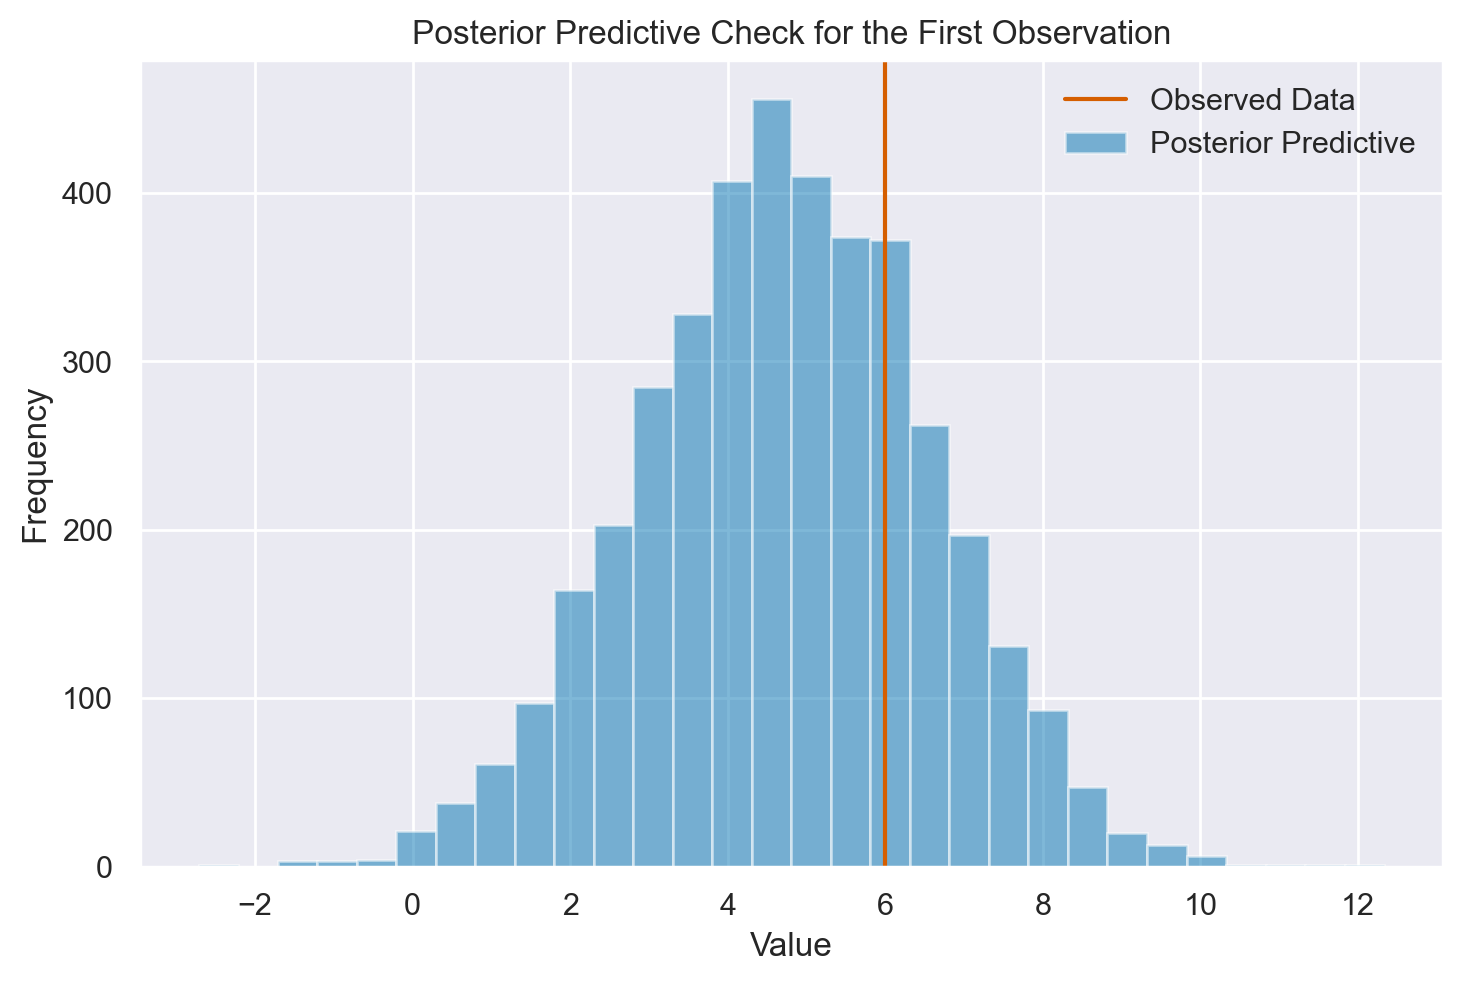

In [87]:
post_pred = ppc.posterior_predictive
y_i_post_pred = post_pred["y"].values[:, :, 0]

plt.hist(y_i_post_pred.flatten(), bins=30, alpha=0.5)
plt.axvline(data[0], color="r")
plt.title("Posterior Predictive Check for the First Observation")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend(["Observed Data", "Posterior Predictive"])
plt.show()

Per la prima osservazione, calcoliamo il valore della funzione di densità di probabilità (PDF) utilizzando ogni coppia di parametri `mu` e `sigma` dalla distribuzione posteriore. Convertiamo poi questi valori della PDF in logaritmi e calcoliamo la media di questi logaritmi. Questo fornisce una stima empirica della ELPD per la prima osservazione.

Selezione della prima osservazione:

In [88]:
y_i = data[0]
y_i

5.993428306022466

Estrazione dei parametri dal campione posteriore:

In [89]:
mu_samples = trace.posterior["mu"].values.flatten()
mu_samples[0:10]

array([4.79289413, 4.81249101, 4.70262076, 4.68269681, 5.05300161,
       4.5963555 , 4.56669298, 5.10101077, 4.83274092, 4.62293247])

In [90]:
sigma_samples = trace.posterior["sigma"].values.flatten()
sigma_samples[0:10]

array([2.03452238, 1.58033655, 1.97327429, 1.68947152, 2.00762103,
       1.66937237, 1.6087742 , 1.8807339 , 1.74777769, 1.78643193])

Calcolo della densità di probabilità per ogni coppia di parametri:

In [91]:
pdf_values = [
    stats.norm.pdf(y_i, mu, sigma) for mu, sigma in zip(mu_samples, sigma_samples)
]

pdf_values[0:5]

[0.16475467035365546,
 0.1909426394443699,
 0.16323153492595321,
 0.17476636477989982,
 0.17806590128235975]

Calcolo del logaritmo delle densità:

In [92]:
log_pdf_values = np.log(pdf_values)
log_pdf_values[0:5]

array([-1.80329776, -1.65578221, -1.81258563, -1.74430526, -1.72560157])

Calcolo della media dei valori logaritmici:

In [93]:
mean_log_density = np.mean(log_pdf_values)
mean_log_density

-1.7478000243511456

Questo calcolo ci fornisce una stima empirica della media della densità logaritmica predittiva (ELPD) per la prima osservazione del campione.

#### Estensione a Tutte le Osservazioni

Ripetiamo il processo per ogni osservazione nel set di dati. Calcoliamo la densità logaritmica predittiva per ogni osservazione utilizzando lo stesso metodo usato per la prima osservazione. Infine, calcoliamo la media di tutte queste densità logaritmiche predittive. Questo valore rappresenta la stima della ELPD per l'intero set di dati.

In [94]:
# Calcolo della densità logaritmica predittiva per ogni osservazione
all_log_densities = []
for y_i in data:
    pdf_values = [
        stats.norm.pdf(y_i, mu, sigma) for mu, sigma in zip(mu_samples, sigma_samples)
    ]
    log_pdf_values = np.log(pdf_values)
    mean_log_density = np.mean(log_pdf_values)
    all_log_densities.append(mean_log_density)

In [95]:
# Calcolo della media su tutte le osservazioni
overall_mean_log_density = np.mean(all_log_densities)
overall_mean_log_density

-2.020915797882413

## Commenti e Considerazioni Finali 

Nel corso di questo capitolo, abbiamo esplorato in profondità il concetto della Densità Logaritmica Predittiva Prevista (ELPD), una metrica fondamentale nell'ambito dell'analisi statistica bayesiana. L'ELPD si distingue non solo come strumento per valutare le prestazioni di un modello statistico, ma assume un ruolo cruciale nel confronto tra diversi modelli.

L'adozione dell'ELPD come criterio di confronto offre una prospettiva oggettiva e basata sui dati per determinare quale modello sia più aderente e rappresentativo rispetto alle informazioni a nostra disposizione. In un panorama scientifico e applicativo di crescente complessità, dove le alternative di modellazione si moltiplicano e divergono, l'ELPD emerge come un faro guida per orientare la scelta verso il modello più appropriato. Questa metrica si rivela particolarmente utile sia nel confronto tra modelli di diversa complessità, sia nella selezione tra vari approcci modellistici, fornendo una valutazione quantitativa e imparziale della loro capacità predittiva.

In sintesi, l'ELPD rappresenta uno strumento imprescindibile nell'arsenale dell'analista dei dati moderno. Il suo impiego in fase di scelta e valutazione dei modelli contribuisce in modo significativo a chiarire e guidare le decisioni analitiche, portando a risultati più robusti e modelli statistici maggiormente efficaci. In definitiva, l'ELPD non solo facilita la comprensione delle performance dei modelli, ma promuove anche una maggiore fiducia nelle previsioni che essi generano, un aspetto fondamentale in qualsiasi campo di applicazione statistica.

## Watermark

In [56]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jan 25 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

scipy      : 1.11.4
numpy      : 1.26.2
pymc       : 5.10.3
pandas     : 2.1.4
seaborn    : 0.13.0
matplotlib : 3.8.2
statsmodels: 0.14.1
arviz      : 0.17.0

Watermark: 2.4.3

